# Tutorial 07 - Signal interactions

## Goals

- Compute the Power Spectrum Density (PSD) and coherence between two signals
- Compute vStr-Hipp coherence between experimental conditions

## Coherence

Let's start by considering how two oscillating signals may be related. 
There are various possible relationships between the two, such as illustrated here 
(from [Siegel et al. 2012](http://www.ncbi.nlm.nih.gov/pubmed/22233726)):

<img src="07-coherence.png" style="width: 500px;">

## Coherence within the ventral striatum (vStr) and between vStr and hippocampus (hipp)

In [1]:
# Import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt
import matplotlib.mlab
import scipy.signal

# Define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R016-2012-10-03')

In [2]:
# Load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r016d3 as info

In [3]:
# Load both LFPs (.ncs) from rat ventral striatum and one from the hippocampus
lfp_vstr1 = nept.load_lfp(os.path.join(data_folder, info.lfp_gamma_filename1))
lfp_vstr2 = nept.load_lfp(os.path.join(data_folder, info.lfp_gamma_filename2))

lfp_hipp = nept.load_lfp(os.path.join(data_folder, info.lfp_theta_filename))

In [4]:
# Let's restrict our LFPs to during task times
task_start = info.task_times['task-value'].start
task_stop = info.task_times['task-reward'].stop

lfp_vstr1 = lfp_vstr1.time_slice(task_start, task_stop)
lfp_vstr2 = lfp_vstr2.time_slice(task_start, task_stop)
lfp_hipp = lfp_hipp.time_slice(task_start, task_stop)

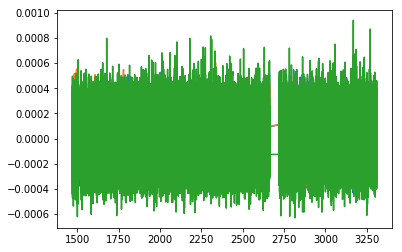

In [5]:
# Plot the LFPs. Notice the break in LFP when the task was switched from 'value' to 'reward'
plt.plot(lfp_vstr1.time, lfp_vstr1.data)
plt.plot(lfp_vstr2.time, lfp_vstr2.data)
plt.plot(lfp_hipp.time, lfp_hipp.data)
plt.show()

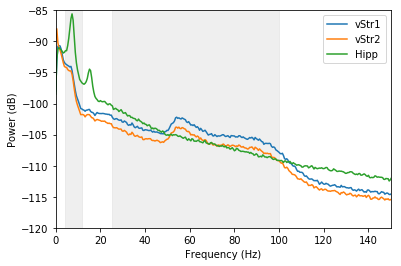

In [6]:
# Compute the Power Spectral Density (PSD) for each signal with Welch’s average
window = 2048
fs = 2000

vstr1 = np.squeeze(lfp_vstr1.data)
vstr2 = np.squeeze(lfp_vstr2.data)
hipp = np.squeeze(lfp_hipp.data)

fig, ax = plt.subplots()

# Theta
ax.axvspan(4, 12, color='#cccccc', alpha=0.3)
# Gamma
ax.axvspan(25, 100, color='#cccccc', alpha=0.3)

for lfp_data in [vstr1, vstr2, hipp]:
    power, freq = matplotlib.mlab.psd(lfp_data, 
                                      Fs=fs,
                                      NFFT=int(window*2),
                                      noverlap=int(window/2))

    power_db = 10*np.log10(power)
    plt.plot(freq, power_db)
    
    plt.xlim(0, 150)
    plt.ylim(-120, -85)
    plt.ylabel('Power (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.legend(['vStr1', 'vStr2', 'Hipp'])
    
plt.show()

Notice the hippocampus has a clear theta (4 - 12 Hz) peak, 
which is visible as only a slight hump in ventral striatum. 
Ventral striatum has large gamma (25 - 100 Hz) components,
which are not present in the hippocampus.

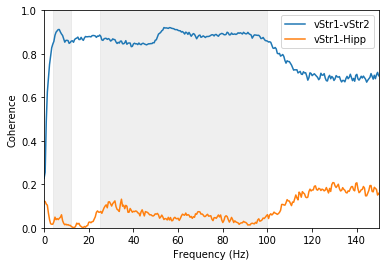

In [7]:
# Compute the coherence for vStr-vStr and vStr-hipp

fig, ax = plt.subplots()

# Theta
ax.axvspan(4, 12, color='#cccccc', alpha=0.3)
# Gamma
ax.axvspan(25, 100, color='#cccccc', alpha=0.3)

for lfp_data in [vstr2, hipp]:
    coherence, freq = matplotlib.mlab.cohere(
        vstr1, lfp_data, Fs=fs, NFFT=int(window*2), noverlap=int(window/2))

    plt.plot(freq, coherence)
    plt.xlim(0, 150)
    plt.ylim(0, 1)
    plt.ylabel('Coherence')
    plt.xlabel('Frequency (Hz)')
    plt.legend(['vStr1-vStr2', 'vStr1-Hipp'])
plt.show()

The coherence between the two ventral striatum signals is high overall 
compared to that between the ventral striatum and hippocampus.
The ventral striatum gamma frequencies are particularly coherent within the ventral striatum. 

## Compute vStr-Hipp coherence between experimental conditions

In [8]:
# Load events from this experiment
events = nept.load_events(os.path.join(data_folder, info.event_filename), info.event_labels)

Let's see if there is a change in coherence between _approach to the reward site_
and _reward receipt_. 

In [9]:
# Get the photobeam break times
pb = np.sort(np.append(events['feeder0'], events['feeder1']))

In [10]:
# Compute the perievent slices for the nosepoke times
np_vstr1 = nept.perievent_slice(lfp_vstr1, pb, t_before=2.5, t_after=5.0)
np_vstr2 = nept.perievent_slice(lfp_vstr2, pb, t_before=2.5, t_after=5.0)
np_hipp = nept.perievent_slice(lfp_hipp, pb, t_before=2.5, t_after=5.0)

In [11]:
# Get the mean PSD for each of our signals
freq, psd_vstr1 = nept.mean_psd(np_vstr1, window, fs)
freq, psd_vstr2 = nept.mean_psd(np_vstr2, window, fs)
freq, psd_hipp = nept.mean_psd(np_hipp, window, fs)

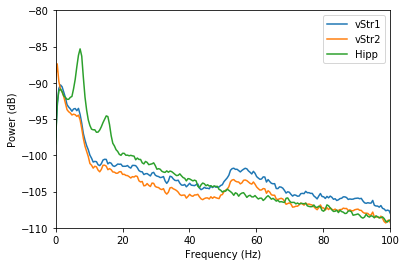

In [12]:
# Plot the PSDs
plt.plot(freq, nept.power_in_db(psd_vstr1))
plt.plot(freq, nept.power_in_db(psd_vstr2))
plt.plot(freq, nept.power_in_db(psd_hipp))
plt.xlim(0, 100)
plt.ylim(-110, -80)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.legend(['vStr1', 'vStr2', 'Hipp'])
plt.show()

In [13]:
# Get the mean PSD for our signals of interest, e.g. vStr1-vStr2 and vStr1-Hipp
freq, csd_vstr1_vstr2 = nept.mean_csd(np_vstr1, np_vstr2, window, fs)
freq, csd_vstr1_hipp = nept.mean_csd(np_vstr1, np_hipp, window, fs)

/home/emily/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


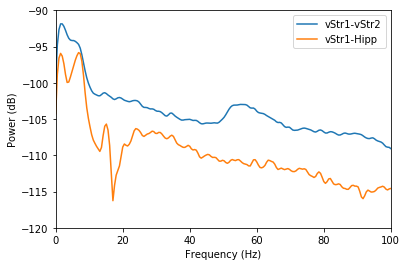

In [14]:
# Plot the CSDs
plt.plot(freq, nept.power_in_db(csd_vstr1_vstr2))
plt.plot(freq, nept.power_in_db(csd_vstr1_hipp))
plt.xlim(0, 100)
plt.ylim(-120, -90)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.legend(['vStr1-vStr2', 'vStr1-Hipp'])
plt.show()

In [15]:
# Get the mean coherence for our signals of interest, e.g. vStr1-vStr2 and vStr1-Hipp
freq, coh_vstr1_vstr2 = nept.mean_coherence(np_vstr1, np_vstr2, window, fs)
freq, coh_vstr1_hipp = nept.mean_coherence(np_vstr1, np_hipp, window, fs)

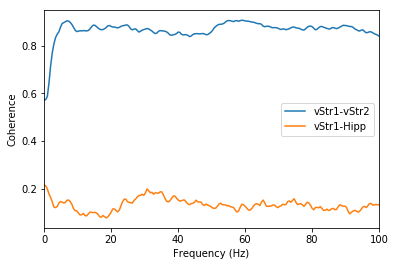

In [16]:
# Plot the coherences
plt.plot(freq, coh_vstr1_vstr2)
plt.plot(freq, coh_vstr1_hipp)
plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.legend(['vStr1-vStr2', 'vStr1-Hipp'])
plt.show()

In [17]:
# Get the mean coherencegram for our signals of interest, e.g. vStr1-vStr2 and vStr1-Hipp
time, freq, coherencegram_vstr1_vstr2 = nept.mean_coherencegram(np_vstr1, np_vstr2, dt=0.07, 
                                                                window=500, fs=fs)
time, freq, coherencegram_vstr1_hipp = nept.mean_coherencegram(np_vstr1, np_hipp, dt=0.07, 
                                                               window=500, fs=fs)

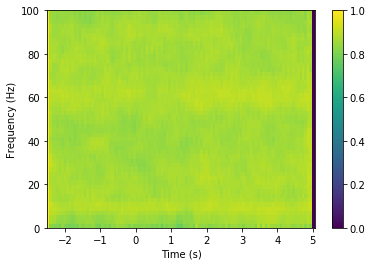

In [18]:
# Plot the vStr1-vStr2 coherencegram
xx, yy = np.meshgrid(time, freq)
plt.pcolormesh(xx, yy, coherencegram_vstr1_vstr2)
plt.ylim(0, 100)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

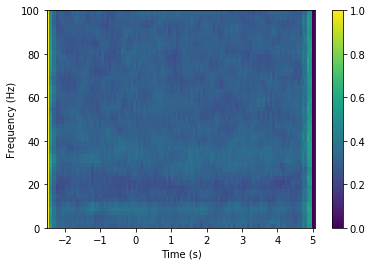

In [19]:
# Plot the vStr1-Hipp coherencegram
xx, yy = np.meshgrid(time, freq)
plt.pcolormesh(xx, yy, coherencegram_vstr1_hipp)
plt.ylim(0, 100)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()